<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/UCSD_Data_Set_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from tensorflow.keras.preprocessing import image

import scipy
from scipy.io import loadmat
import glob
import h5py
import time
from sklearn.externals.joblib import Parallel, delayed
from torchvision import datasets, transforms

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
test_setpath = "/content/drive/MyDrive/Model_Test_Data/UCSD/vidf-cvpr/vidf1_33_000_people_full.mat"

In [59]:
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    #print(gt_count)
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    pts_copy = pts.copy()
    tree = scipy.spatial.KDTree(pts_copy, leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)
    print('generate density...')
    #print(locations)
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1], pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(gt.shape)) / 2. / 2.  # case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [ ]:
def generate_density_map(img_path):
    img_path = "/content/drive/MyDrive/Model_Test_Data/UCF-QNRF/UCF-QNRF_ECCV18/Test/"+ img_path
    #print(img_path)
    mat_path = img_path.replace('.jpg', '.mat').replace('.','_ann.')
    #print(mat_path)
    mat = scipy.io.loadmat(mat_path)
    imgfile = image.load_img(img_path)
    img = image.img_to_array(imgfile)
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = mat["annPoints"]
    #print(mat)
    #print(gt)
    for i in range(0, len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1
    k = gaussian_filter_density(k)
    output_path = img_path.replace('.jpg', '.h5').replace('Test/','ground-truth-h5/')
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)
    print("output", output_path)
    with h5py.File(output_path, 'w') as hf:
        hf['density'] = k
    return img_path

In [44]:
mat_path = "/content/drive/MyDrive/Model_Test_Data/UCSD/vidf-cvpr/vidf1_33_005_frame_full.mat"
mat = scipy.io.loadmat(mat_path)

In [45]:
mat['frame'][0][0][0][0][2]

array([[ 0.87431694, -0.22107081,  1.        ],
       [ 0.66885246, -0.2597582 ,  1.        ],
       [ 0.32786885, -0.30397237,  1.        ],
       [ 0.31038251, -0.21001727,  1.        ],
       [ 0.3715847 , -0.19896373,  1.        ],
       [-0.19672131,  0.17685665,  1.        ],
       [-0.17923497,  0.21554404,  1.        ],
       [-0.13114754,  0.11053541,  1.        ],
       [ 0.38469945, -0.32607945,  1.        ],
       [-1.24590164,  0.58031088,  1.        ],
       [-0.19672131,  0.13816926,  1.        ],
       [ 0.52459016, -0.22659758,  1.        ],
       [ 0.51584699, -0.08842832,  1.        ],
       [ 0.34972678, -0.03868739,  1.        ],
       [ 0.63387978, -0.36476684,  1.        ],
       [ 0.38907104, -0.28186528,  1.        ],
       [-1.57377049,  0.55267703,  1.        ],
       [-0.45901639,  0.41450777,  1.        ],
       [ 0.45901639, -0.13816926,  1.        ],
       [ 1.04918033, -0.88428325,  1.        ],
       [-0.20546448,  0.16027634,  1.   

In [72]:
img_path = '/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/vidf1_33_005_f001.png'
imgfile = image.load_img(img_path)
img = image.img_to_array(imgfile)
k = np.zeros((img.shape[0], img.shape[1]))

In [80]:
gt = mat['frame'][0][0][0][0][1]
print(gt[0])

[80 84 77 76 72 87 89 70 73 69 71 79 78 81 82 83 92 59 65 93 90 91 88]


In [67]:
gt = mat['frame'][0][0][0][0][0]
for i in range(0, len(gt)):
  if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
    k[int(gt[i][1]), int(gt[i][0])] = 1
k = gaussian_filter_density(k)
output_path = img_path.replace('.png', '.h5').replace('vidf1_33_005.y/','vidf1_33_005.y/gt-h5/')
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)
print("output", output_path)
with h5py.File(output_path, 'w') as hf:
  hf['density'] = k
print(img_path)

(158, 238)
generate density...
done.
output /content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/gt-h5/vidf1_33_005_f001.h5
/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/vidf1_33_005_f001.png


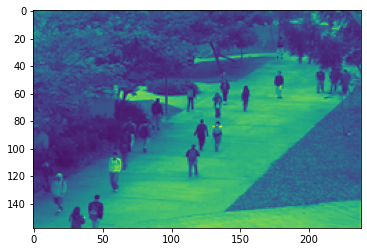

In [69]:
img_path = "/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/vidf1_33_005_f001.png"
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

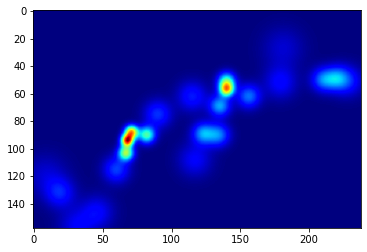

In [70]:

density_map_path = "/content/drive/MyDrive/Model_Test_Data/UCSD/ucsdpeds/vidf/vidf1_33_005.y/gt-h5/vidf1_33_005_f001.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [71]:
print(np.sum(groundtruth))

22.189436
